# K-NN

## 1- Load the required modeules

In [23]:
import numpy as np   
import pandas as pd
import matplotlib.pyplot as plt        
import sklearn
import sklearn.datasets as ds            
import sklearn.model_selection as cv   
import sklearn.neighbors as nb      
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import cross_val_predict  
from sklearn.metrics import accuracy_score
%matplotlib inline                     

## 2- Load the data

In [20]:
data = pd.read_csv('../datasets/preprocessed/train.csv', sep=',')
print(data.shape)

(1438, 48)


## 3.1- Only numerical features

In [21]:
Y = data['SalePrice'].to_numpy()
X = data.select_dtypes(include=['float64','int64']).to_numpy() # only numerical
(X_train, X_test,  y_train, y_test) = cv.train_test_split(X, Y, test_size=.3, random_state=1)

### 10 cross-validation

In [11]:
cv_scores = cross_val_score(nb.KNeighborsClassifier(),  
                            X=X,  
                            y=Y,  
                            cv=10, scoring='accuracy')  

# cv_scores is a list with 10 accuracies (one for each validation)
print(cv_scores)

[0.74305556 0.73611111 0.72222222 0.76388889 0.72222222 0.77083333
 0.72222222 0.74305556 0.74825175 0.73426573]


In [12]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.7406128593628594
0.01612617464859391


### Find best parameters

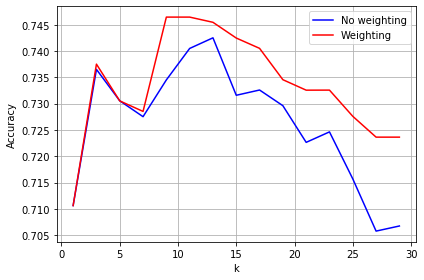

Grid search best params= {'n_neighbors': 9, 'weights': 'distance'} Accuracy= 0.7464554455445545


In [14]:
# Method 1
lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki), X=X_train, y=y_train, cv=10)
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'b',label='No weighting')

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance'), X=X_train, y=y_train, cv=10)
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'r',label='Weighting')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.show()

# Method 2
params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
clf.fit(X_train, y_train)
print("Grid search best params=",clf.best_params_, "Accuracy=", clf.best_score_)

### See results with test data

In [15]:
parval=clf.best_params_
knc = nb.KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print(sklearn.metrics.confusion_matrix(y_test, pred))
print(sklearn.metrics.accuracy_score(y_test, pred))

[[ 13  24   0   0   0]
 [  4 245  29   0   0]
 [  0  29  50   5   0]
 [  0   1  21   7   0]
 [  0   0   0   4   0]]
0.7291666666666666


## 3.2- Only categorical features

In [31]:
Y = data['SalePrice'].to_numpy()
X = data.drop(['SalePrice'], axis=1)
X = X.select_dtypes(include=['object','bool']) # only categorical
le = preprocessing.LabelEncoder()
i = 0
for t in X.dtypes:
    le.fit(X.iloc[:,i])
    X.iloc[:,i] = le.fit_transform(X.iloc[:,i]) # transform them to numerical
    i += 1
X = X.to_numpy()
(X_train, X_test,  y_train, y_test) = cv.train_test_split(X, Y, test_size=.3, random_state=1)

### 10 cross-validation

In [32]:
cv_scores = cross_val_score(nb.KNeighborsClassifier(),  
                            X=X,  
                            y=Y,  
                            cv=10, scoring='accu# Method 1
lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki), X=X_train, y=y_train, cv=10)
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'b',label='No weighting')

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance'), X=X_train, y=y_train, cv=10)
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'r',label='Weighting')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.show()

# Method 2
params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
clf.fit(X_train, y_train)
print("Grid search best params=",clf.best_params_, "Accuracy=", clf.best_score_)racy')  

# cv_scores is a list with 10 accuracies (one for each validation)
print(cv_scores)

[0.71527778 0.68055556 0.72222222 0.72916667 0.72222222 0.75
 0.6875     0.70138889 0.67132867 0.72027972]


In [33]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.7099941724941725
0.023113852978956864


### Find best parameters

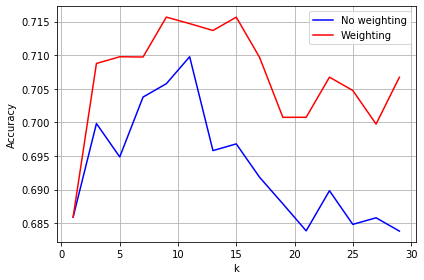

Grid search best params= {'n_neighbors': 9, 'weights': 'distance'} Accuracy= 0.7156732673267328


In [34]:
# Method 1
lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki), X=X_train, y=y_train, cv=10)
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'b',label='No weighting')

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance'), X=X_train, y=y_train, cv=10)
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'r',label='Weighting')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.show()

# Method 2
params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
clf.fit(X_train, y_train)
print("Grid search best params=",clf.best_params_, "Accuracy=", clf.best_score_)

### See results with test data

In [29]:
parval=clf.best_params_
knc = nb.KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print(sklearn.metrics.confusion_matrix(y_test, pred))
print(sklearn.metrics.accuracy_score(y_test, pred))

[[  9  28   0   0   0]
 [  3 250  25   0   0]
 [  0  32  50   2   0]
 [  0   8  12   9   0]
 [  0   0   0   3   1]]
0.7384259259259259


## 3.3- Categorical and numerical features

In [38]:
Y = data['SalePrice'].to_numpy()
X = data.drop(['SalePrice'], axis=1)
le = preprocessing.LabelEncoder()
i = 0
for t in X.dtypes:
    if t==object or t==bool:
        le.fit(X.iloc[:,i])
        X.iloc[:,i] = le.fit_transform(X.iloc[:,i]) # transform them to numerical
    i += 1
X = X.to_numpy()
(X_train, X_test,  y_train, y_test) = cv.train_test_split(X, Y, test_size=.3, random_state=1)

### 10 cross-validation

In [39]:
cv_scores = cross_val_score(nb.KNeighborsClassifier(),  
                            X=X,  
                            y=Y,  
                            cv=10, scoring='accuracy')  

# cv_scores is a list with 10 accuracies (one for each validation)
print(cv_scores)

[0.70833333 0.67361111 0.74305556 0.72222222 0.72222222 0.75694444
 0.72916667 0.70833333 0.67832168 0.70629371]


In [40]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.7148504273504275
0.024646034515094062


### Find best parameters

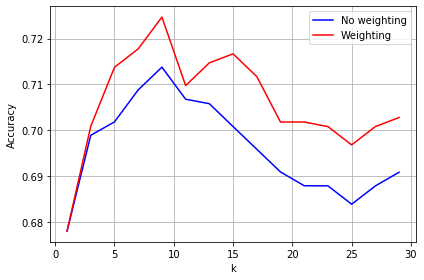

Grid search best params= {'n_neighbors': 9, 'weights': 'distance'} Accuracy= 0.7246732673267327


In [41]:
# Method 1
lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki), X=X_train, y=y_train, cv=10)
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'b',label='No weighting')

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance'), X=X_train, y=y_train, cv=10)
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'r',label='Weighting')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.show()

# Method 2
params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
clf.fit(X_train, y_train)
print("Grid search best params=",clf.best_params_, "Accuracy=", clf.best_score_)

### See results with test data

In [42]:
parval=clf.best_params_
knc = nb.KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print(sklearn.metrics.confusion_matrix(y_test, pred))
print(sklearn.metrics.accuracy_score(y_test, pred))

[[  8  29   0   0   0]
 [  3 238  36   1   0]
 [  0  35  47   2   0]
 [  0  10  10   9   0]
 [  0   0   0   4   0]]
0.6990740740740741


### [Optional] Let's see how ammount of training data influences accuracy 

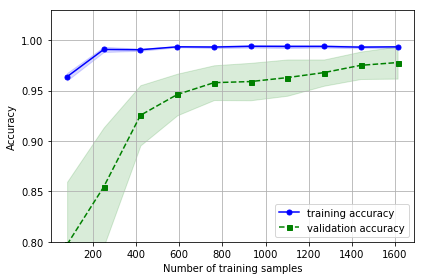

In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=nb.KNeighborsClassifier(n_neighbors=3),
                               X=X,
                               y=y,
                               train_sizes=np.linspace(0.05, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=600)
plt.show()

## 5- Finding parameters for k-NN

In [19]:
# interval confidence
from statsmodels.stats.proportion import proportion_confint

epsilon = sklearn.metrics.accuracy_score(y_test, pred)
print("Can approximate by Normal Distribution?: ",X_test.shape[0]*epsilon*(1-epsilon)>5)
print("Interval 95% confidence:", "{0:.3f}".format(epsilon), "+/-", "{0:.3f}".format(1.96*np.sqrt(epsilon*(1-epsilon)/X_test.shape[0])))
# or equivalent 
proportion_confint(count=epsilon*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='normal')

Can approximate by Normal Distribution?:  False
Interval 95% confidence: 0.991 +/- 0.008


(0.98266245251249873, 0.99881902896898267)

In [20]:
#Using Binomial distribution

proportion_confint(count=epsilon*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test')

(0.9781611871249579, 0.9963446921115061)

### Mcnemar's Test implementation

In [21]:
# Build two classifiers

# Classifier 1 (3 Neighbours) successes
y_pred = cross_val_predict(nb.KNeighborsClassifier(n_neighbors=3), X=X, y=y,  cv=10) 
res1=np.zeros(y.shape)
res1[y_pred==y]=1

# Classifier 2 (7 Neighbours) 2 successes
y_pred = cross_val_predict(nb.KNeighborsClassifier(n_neighbors=7), X=X, y=y,  cv=10) 
res2=np.zeros(y.shape)
res2[y_pred==y]=1

# Build contingency matrix
n00 = np.sum([res1[res2==1]==1])
n11 = np.sum([res1[res2==0]==0])
n10 = np.sum([res1[res2==1]==0])
n01 = np.sum([res1[res2==0]==1])

# Chi -square test
print("Have the classifiers significant different accuracy?:",(np.abs(n01-n10)-1)**2/(n01+n10)>3.84)

Have the classifiers significant different accuracy?: True


### Take a look to the errors in test set

Guess: 9 Reality: 7


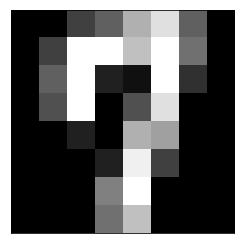

Guess: 7 Reality: 2


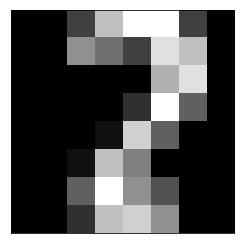

Guess: 9 Reality: 5


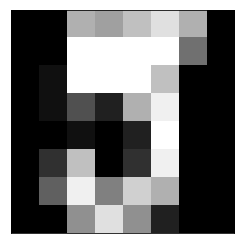

Guess: 1 Reality: 8


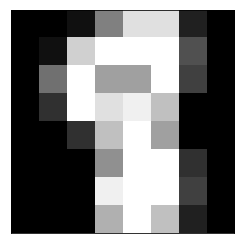

Guess: 5 Reality: 9


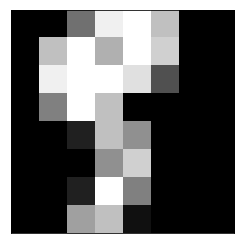

In [22]:
testerrors=[i for i,k in enumerate(pred) if k!=y_test[i]]
plt.gray()
plt.ion
for i in testerrors:
    plt.matshow(X_test[i].reshape(8,8))
    plt.xticks([]); plt.yticks([]);
    print("Guess:", pred[i],"Reality:",y_test[i])
    plt.show()

# Exercises:

### Do a 10-fold Cross-Validation using Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB  # For numerical featuresm assuming normal distribution
from sklearn.naive_bayes import MultinomialNB  # For features with counting numbers (f.i. hown many times word appears in doc)
from sklearn.naive_bayes import BernoulliNB  # For binari features (f.i. word appears or not in document)

# No parameters to tune

clf = GaussianNB()
pred = clf.fit(X_train, y_train).predict(X_test)
print(sklearn.metrics.confusion_matrix(y_test, pred))
print()
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, pred))
print()
print(metrics.classification_report(y_test, pred))
epsilon = sklearn.metrics.accuracy_score(y_test, pred)
proportion_confint(count=epsilon*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test')

[[54  1  0  0  3  0  0  1  0  0]
 [ 0 42  1  0  0  0  0  0  6  0]
 [ 0  5 32  0  0  0  0  0 12  0]
 [ 0  2  2 51  0  1  0  3  5  0]
 [ 1  4  0  0 54  0  0  1  1  0]
 [ 0  2  0  1  0 41  0  2  1  0]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 57  0  0]
 [ 0 10  0  1  0  0  0  1 34  0]
 [ 0  2  0  1  2  3  1  7  8 33]]

Accuracy: 0.831481481481

             precision    recall  f1-score   support

          0       0.98      0.92      0.95        59
          1       0.62      0.86      0.72        49
          2       0.91      0.65      0.76        49
          3       0.94      0.80      0.86        64
          4       0.92      0.89      0.90        61
          5       0.91      0.87      0.89        47
          6       0.98      1.00      0.99        51
          7       0.79      1.00      0.88        57
          8       0.51      0.74      0.60        46
          9       1.00      0.58      0.73        57

avg / total       0.87      0.83      0.83       540



(0.7973917698694923, 0.861327901247561)

### Reproduce in Rapidminer

In [24]:
# Export data to Rapidminer

import pandas as pd 
df = pd.DataFrame(np.c_[ digits.data, digits.target])
df.to_csv("digits2.csv",index=False)

# Go to Rapidminer and load the data set. Reproduce grid Search there and report results on the test set

### Play with noise

In [25]:
# Lets' add noise to data: 64 new columns with random data
nrcols=64
col = np.random.randint(0,17,(X_train.data.shape[0],nrcols))
col

array([[12, 12, 11, ...,  1, 12,  6],
       [12,  4, 14, ...,  7,  1,  6],
       [ 0,  3,  2, ...,  4, 10, 15],
       ..., 
       [ 4,  6,  2, ...,  9, 12,  1],
       [12,  9,  6, ..., 10,  3,  3],
       [ 8,  1,  8, ...,  0,  3,  7]])

In [26]:
Xr=np.hstack((X_train,col))
Xr

array([[  0.,   0.,   2., ...,   1.,  12.,   6.],
       [  0.,   0.,   3., ...,   7.,   1.,   6.],
       [  0.,   0.,   6., ...,   4.,  10.,  15.],
       ..., 
       [  0.,   0.,   7., ...,   9.,  12.,   1.],
       [  0.,   0.,   0., ...,  10.,   3.,   3.],
       [  0.,   0.,   8., ...,   0.,   3.,   7.]])

In [27]:
col = np.random.randint(0,17,(X_test.data.shape[0],nrcols))
Xr_test=np.hstack((X_test,col))

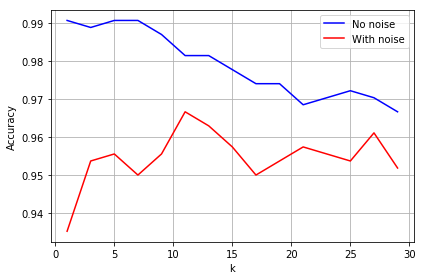

In [28]:
lr = []
for ki in range(1,30,2):
    knc = nb.KNeighborsClassifier(n_neighbors=ki)
    knc.fit(X_train, y_train)
    lr.append(knc.score(X_test, y_test))         
plt.plot(range(1,30,2),lr,'b',label='No noise')

lr = []
for ki in range(1,30,2):
    knc = nb.KNeighborsClassifier(n_neighbors=ki)
    knc.fit(Xr, y_train)
    lr.append(knc.score(Xr_test, y_test))  
plt.plot(range(1,30,2),lr,'r',label='With noise')

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.show()

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

fs = SelectKBest(mutual_info_classif, k=64).fit(Xr, y_train) #chi2
X_new = fs.transform(Xr)
Xtr_new = fs.transform(Xr_test)

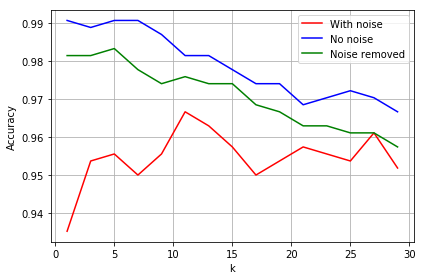

In [30]:
lr = []
for ki in range(1,30,2):
    knc = nb.KNeighborsClassifier(n_neighbors=ki)
    knc.fit(Xr, y_train)
    lr.append(knc.score(Xr_test, y_test))    
plt.plot(range(1,30,2),lr,'r',label='With noise')

lr = []
for ki in range(1,30,2):
    knc = nb.KNeighborsClassifier(n_neighbors=ki)
    knc.fit(X_train, y_train)
    lr.append(knc.score(X_test, y_test))   
plt.plot(range(1,30,2),lr,'b',label='No noise')

lr = []
for ki in range(1,30,2):
    knc = nb.KNeighborsClassifier(n_neighbors=ki)
    knc.fit(X_new, y_train)
    lr.append(knc.score(Xtr_new, y_test))   
plt.plot(range(1,30,2),lr,'g',label='Noise removed')

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.show()

### Change the scorer function

In [34]:
#Let's try to optimize parameters for precision of class "9"

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer

params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1,scoring="accuracy") 
clf.fit(X_train, y_train)
print("Best Params=",clf.best_params_, "Accuracy=", clf.best_score_)

parval=clf.best_params_
knc = nb.KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print(sklearn.metrics.confusion_matrix(y_test, pred))
print(sklearn.metrics.accuracy_score(y_test, pred))
print(metrics.classification_report(y_test, pred))

print('Precision for "9": %.3f' % precision_score(y_true=y_test, y_pred=pred,average='macro',labels=[9]))

Best Params= {'n_neighbors': 3, 'weights': 'distance'} Accuracy= 0.984089101034
[[59  0  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  0  0]
 [ 0  0 48  0  0  0  0  1  0  0]
 [ 0  0  0 64  0  0  0  0  0  0]
 [ 0  0  0  0 61  0  0  0  0  0]
 [ 0  0  0  0  0 46  0  0  0  1]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 56  0  1]
 [ 0  1  0  0  0  0  0  0 45  0]
 [ 0  0  0  0  0  1  0  0  0 56]]
0.990740740741
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        59
          1       0.98      1.00      0.99        49
          2       1.00      0.98      0.99        49
          3       1.00      1.00      1.00        64
          4       1.00      1.00      1.00        61
          5       0.98      0.98      0.98        47
          6       1.00      1.00      1.00        51
          7       0.98      0.98      0.98        57
          8       1.00      0.98      0.99        46
          9       0.97      0.98      0.97 

In [35]:
# Precison of class 9 is low compared with others. 
# Assume precision of "9" is critical. Let's change optimize parameters by defining precision for 9.

scorer = make_scorer(precision_score,average='macro',labels=[9])
#scorer = make_scorer(score_func=precision_score, pos_label=9, greater_is_better=True,average='micro')


params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1,scoring=scorer) 
clf.fit(X_train, y_train)
print("Best Params=",clf.best_params_, "Precision=", clf.best_score_)

parval=clf.best_params_
knc = nb.KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print(sklearn.metrics.confusion_matrix(y_test, pred))
print(sklearn.metrics.accuracy_score(y_test, pred))
print(metrics.classification_report(y_test, pred))


Best Params= {'n_neighbors': 7, 'weights': 'distance'} Precision= 0.98507697553
[[58  0  0  0  1  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  0  0]
 [ 0  0 48  0  0  0  0  1  0  0]
 [ 0  0  0 64  0  0  0  0  0  0]
 [ 0  0  0  0 61  0  0  0  0  0]
 [ 0  0  0  0  0 46  0  0  0  1]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 57  0  0]
 [ 0  1  0  0  0  0  0  0 45  0]
 [ 0  0  0  0  0  1  0  0  0 56]]
0.990740740741
             precision    recall  f1-score   support

          0       1.00      0.98      0.99        59
          1       0.98      1.00      0.99        49
          2       1.00      0.98      0.99        49
          3       1.00      1.00      1.00        64
          4       0.98      1.00      0.99        61
          5       0.98      0.98      0.98        47
          6       1.00      1.00      1.00        51
          7       0.98      1.00      0.99        57
          8       1.00      0.98      0.99        46
          9       0.98      0.98      0.98 

Guess: 4 Reality: 0


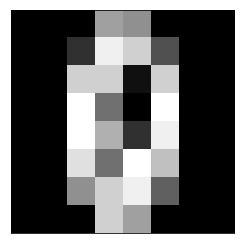

Guess: 7 Reality: 2


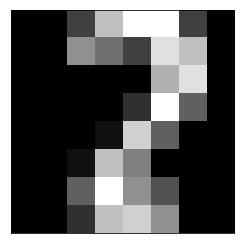

Guess: 9 Reality: 5


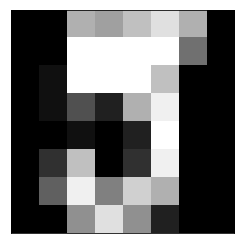

Guess: 1 Reality: 8


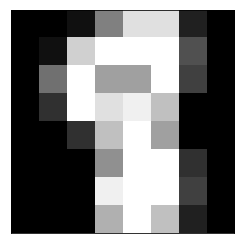

Guess: 5 Reality: 9


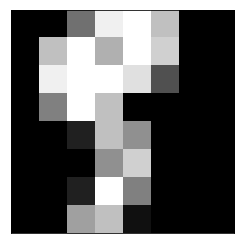

In [36]:
testerrors=[i for i,k in enumerate(pred) if k!=y_test[i]]
plt.gray()
plt.ion
for i in testerrors:
    plt.matshow(X_test[i].reshape(8,8))
    plt.xticks([]); plt.yticks([]);
    print("Guess:", pred[i],"Reality:",y_test[i])
    plt.show()